In [1]:
from collections import OrderedDict
from typing import Dict, List, Tuple, Optional, Union

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import Dataset, DataLoader, random_split
import nibabel as nib
from pathlib import Path
from dotenv import load_dotenv
import wandb
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context, ndarrays_to_parameters
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr.common import NDArrays, Scalar, Context
from flwr.common import (
    EvaluateRes,
    FitRes,
)
from flwr.server.client_proxy import ClientProxy

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()
torch.set_float32_matmul_precision('medium')

Training on cuda
Flower 1.18.0 / PyTorch 2.5.1


In [2]:
load_dotenv()
WANDB_APIKEY = os.getenv("WANDB_APIKEY")

In [3]:
NUM_CLIENTS = 10
EPOCHS = 1
NUM_ROUNDS = 10

In [4]:
wandb.login(key=WANDB_APIKEY)

wandb.init(
            project="federated-mri-server",
            name=f"all_run_c{NUM_CLIENTS}_e{EPOCHS}_r{NUM_ROUNDS}",
            group="server",
        )

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: trungquang123a (trungquang123a-uet-vnu-org-test). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\TrungNg\_netrc
c:\Users\TrungNg\.conda\envs\python3.11\Lib\site-packages\wandb\sdk\wandb_init.py:202: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  settings = self._wl.settings.copy()
c:\Users\TrungNg\.conda\en

In [5]:
im = nib.load('not_skull_stripped\\sub-BrainAge000019\\anat\\sub-BrainAge000019_T1w.nii\\sub-BrainAge000019_T1w.nii')
data = im.get_fdata()
data.shape, im.affine, im.header

((130, 130, 130),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 <nibabel.nifti1.Nifti1Header at 0x1fa1131ab90>)

In [6]:
data_dir = 'not_skull_stripped'
label_path = list(Path(data_dir).glob("*.xlsx"))
label_ls = pd.read_excel(label_path[0])

In [7]:
label_ls = label_ls[(label_ls['subject_dx'] == 'control') & ((label_ls['subject_sex'] == 'm') | (label_ls['subject_sex'] == 'f'))]

In [8]:
sexes = label_ls[['subject_sex','subject_id']]
sexes.head()

,subject_sex,subject_id
0,m,sub-BrainAge000019
1,m,sub-BrainAge000020
2,m,sub-BrainAge000021
3,m,sub-BrainAge000022
4,f,sub-BrainAge000023


In [9]:
sexes_dict = sexes.set_index('subject_id')['subject_sex'].to_dict()
len(sexes_dict)

8764

In [10]:
class MRIDataset(Dataset):
    def __init__(self, im_dir, label_ls, transform=None):
        self.im_dir = Path(im_dir)
        self.label_ls = label_ls
        self.transform = transform

        # Gather valid image paths
        self.im_filenames = [
            path for path in sorted(self.im_dir.glob("*/*/*/*.nii"))
            if self._is_valid(path)
        ]

    def preprocessing_datapoint(self, img_data):

        mid_x = img_data.shape[0] // 2
        mid_y = img_data.shape[1] // 2
        mid_z = img_data.shape[2] // 2

        axial_slice = img_data[:, :, mid_z]
        coronal_slice = img_data[:, mid_y, :]
        sagittal_slice = img_data[mid_x, :, :]


        combined_data = np.stack([axial_slice, coronal_slice, sagittal_slice], axis=0)
        combined_data = torch.from_numpy(combined_data).float()

        if self.transform : combined_data = self.transform(combined_data)

        return combined_data

    def _is_valid(self, path):
        subject_id = self.extract_subject_id(path)
        if subject_id not in self.label_ls:
            return False
        try:
            nib.load(path).get_fdata()  # just try loading (don't call get_fdata() yet)
            return True
        except Exception:
            return False

    def extract_subject_id(self, im_path):
        for part in Path(im_path).parts:
            if part.startswith("sub-BrainAge"):
                return part
        return None

    def __len__(self):
        return len(self.im_filenames)

    def __getitem__(self, idx):
        im_path = self.im_filenames[idx]
        im = nib.load(im_path).get_fdata()
        im = (im - np.min(im)) / (np.max(im) - np.min(im) + 1e-5)  # avoid divide-by-zero
        im = im.astype(np.float32)
        subject_id = self.extract_subject_id(im_path)
        sex = self.label_ls.get(subject_id)
        if sex == 'm':
            label = 0
        elif sex == 'f':
            label = 1
        else:
            raise ValueError(f"Invalid label for subject {subject_id}: {sex}")

        return self.preprocessing_datapoint(im), label

In [11]:
def iid_client_split(dataset, num_client = 3, partition_id = 0, val_ratio = 0.2):
    sample_per_client = len(dataset) // num_client

    for i in range(num_client):
        start_idx = partition_id * sample_per_client
        end_idx = (partition_id + 1) * sample_per_client if i < num_client - 1 else len(dataset)
        indecies = list(range(start_idx, end_idx))

        client_dataset = torch.utils.data.Subset(dataset, indecies)
        train_dataset, val_dataset = random_split(client_dataset, [1 - val_ratio, val_ratio])
        return (train_dataset, val_dataset)

In [12]:
BATCH_SIZE = 16

datasets = MRIDataset(data_dir, sexes_dict)

def load_datasets(datasets, num_partition: int, partition_id: int):
    client_datasets = iid_client_split(datasets, num_client=num_partition, partition_id=partition_id, val_ratio=0.2)
    return client_datasets

In [ ]:
### MODEL
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict

def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return bn_function

class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False))
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False))
        self.drop_rate = drop_rate
        self.memory_efficient = memory_efficient

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.memory_efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)

class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

class DenseNet121(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_featuremaps=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False,
                 compression_factor = 0.5, grayscale=False):

        super(DenseNet121, self).__init__()

        # First convolution
        if grayscale:
            in_channels=1
        else:
            in_channels=3
        
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(in_channels=in_channels, out_channels=num_init_featuremaps,
                                kernel_size=7, stride=2,
                                padding=3, bias=False)), # bias is redundant when using batchnorm
            ('norm0', nn.BatchNorm2d(num_features=num_init_featuremaps)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_featuremaps
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=int(num_features * compression_factor))
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = int(num_features * compression_factor)

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        logits = self.classifier(out)
        return logits

In [14]:
from torchmetrics import MeanMetric, Accuracy, F1Score, Precision, Recall
import lightning.pytorch as pl

class DenseNetModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, weight_decay = 1e-2):
        super().__init__()
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay
        # how confidence model is in it prediction
        # tức model có thể rất tự tin trong quyết định nhưng thực tế lại sai
        # BCE = y*log(y_pred) + (1 - y)*log(1 - y_pred)
        self.criterion = nn.CrossEntropyLoss()
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()
        self.train_acc = Accuracy(
            task="multiclass", num_classes=model.classifier.out_features
        )
        self.val_acc = Accuracy(
            task="multiclass", num_classes=model.classifier.out_features
        )

        self.test_acc = Accuracy(
            task="multiclass", num_classes=model.classifier.out_features
        )

        # F1 score
        self.val_f1 = F1Score(
            task="multiclass", num_classes=model.classifier.out_features
        )
        self.test_f1 = F1Score(
            task="multiclass", num_classes=model.classifier.out_features
        )
        # Precision
        self.val_precision = Precision(
            task="multiclass", num_classes=model.classifier.out_features
        )
        self.test_precision = Precision(
            task="multiclass", num_classes=model.classifier.out_features
        )
        # Recall
        self.val_recall = Recall(
            task="multiclass", num_classes=model.classifier.out_features
        )
        self.test_recall = Recall(
            task="multiclass", num_classes=model.classifier.out_features
        )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        # x.shape  = (batch_size, in_channel, height, width, depth), y.shape = (batch_size)
        logits = self(x)
        
        loss = self.criterion(logits, y)
        self.train_loss(loss)
        preds = torch.max(F.softmax(logits, dim=1), 1)[1]
        acc = self.train_acc(preds, y)
        
        self.log("train/loss", self.train_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        
        loss = self.criterion(logits, y)
        self.val_loss(loss)
        preds = torch.max(F.softmax(logits, dim=1), 1)[1]
        acc = self.val_acc(preds, y)
        f1 = self.val_f1(preds, y)
        precision = self.val_precision(preds, y)
        recall = self.val_recall(preds, y)
        
        self.log('val/loss', self.val_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val/acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/f1", f1, on_step=False, on_epoch=True, prog_bar=True)
        self.log(
            "val/precision", precision, on_step=False, on_epoch=True, prog_bar=True
        )
        self.log("val/recall", recall, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        
        loss = self.criterion(logits, y)
        self.test_loss(loss)
        preds = torch.max(F.softmax(logits, dim=1), 1)[1]
        acc = self.test_acc(preds, y)
        f1 = self.test_f1(preds, y)
        precision = self.test_precision(preds, y)
        recall = self.test_recall(preds, y)
        
        self.log('test/loss', self.test_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test/acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test/f1", f1, on_step=False, on_epoch=True, prog_bar=True)
        self.log(
            "test/precision", precision, on_step=False, on_epoch=True, prog_bar=True
        )
        self.log("test/recall", recall, on_step=False, on_epoch=True, prog_bar=True)

        return loss


    def configure_optimizers(self):
        optimizer =  torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay = self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)

        return {
           "optimizer": optimizer,
           "lr_scheduler": {
               "scheduler": scheduler,
               "monitor": "val_loss",
           },
        }

In [15]:
# net = DenseNet121(num_classes=2).to(DEVICE)
# module = DenseNetModule(net, lr = 1e-4)
# central_train, central_val, central_test = random_split(datasets, [0.7, 0.2, 0.1])
# early_stopping = EarlyStopping(monitor = "val/loss", min_delta=0.0, patience=3, mode = "min", strict = True)

# trainer = pl.Trainer(
#         max_epochs=20,
#         logger=WandbLogger(project="federated-mri-server", name=f"centralized_r20"),
#         accelerator="auto",
#         devices="auto",
#         log_every_n_steps=10,
#     )
    

# train_loader = DataLoader(central_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
# val_loader = DataLoader(central_val, batch_size=BATCH_SIZE, pin_memory=True)
# test_loader = DataLoader(central_test, batch_size=BATCH_SIZE, pin_memory=True)
# trainer.fit(module, train_loader, val_loader)
# trainer.test(module, test_loader)

In [16]:
# wandb.finish()

In [17]:
### Flower seperation ###

In [18]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.as_tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [19]:
class FlowerClient(NumPyClient):
    def __init__(self, module: pl.LightningModule, trainloader, valloader, partition_id):
        self.module = module
        self.trainloader = trainloader
        self.valloader = valloader
        self.partition_id = partition_id
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.wandb_logger = WandbLogger(project="federated-mri-server", log_model=True)
        self.checkpoint_cb = ModelCheckpoint(monitor='val/loss', save_top_k=1, mode='min')

    def get_parameters(self, config):
        return get_parameters(self.module.model)

    def fit(self, parameters, config):
        set_parameters(self.module.model, parameters)
        trainer = Trainer(
            max_epochs=EPOCHS,
            logger=self.wandb_logger,
            callbacks=[self.checkpoint_cb],
            accelerator="auto",
            devices="auto",
            log_every_n_steps=10,
            enable_progress_bar=False,
        )
        trainer.fit(self.module, self.trainloader, self.valloader)
        callback_metrics = trainer.callback_metrics

        train_loss = callback_metrics.get("train/loss", 0)
        train_accuracy = callback_metrics.get("train/acc", 0)
        val_loss = callback_metrics.get("val/loss", 0)
        val_accuracy = callback_metrics.get("val/acc", 0)
        val_precision = callback_metrics.get("val/precision", 0)
        val_recall = callback_metrics.get("val/recall", 0)
        val_f1 = callback_metrics.get("val/f1", 0)
        metrics = {
            "train_loss": (
                train_loss.item()
                if isinstance(train_loss, torch.Tensor)
                else float(train_loss)
            ),
            "train_accuracy": (
                train_accuracy.item()
                if isinstance(train_accuracy, torch.Tensor)
                else float(train_accuracy)
            ),
            "val_loss": (
                val_loss.item()
                if isinstance(val_loss, torch.Tensor)
                else float(val_loss)
            ),
            "val_accuracy": (
                val_accuracy.item()
                if isinstance(val_accuracy, torch.Tensor)
                else float(val_accuracy)
            ),
            "val_precision": (
                val_precision.item()
                if isinstance(val_precision, torch.Tensor)
                else float(val_precision)
            ),
            "val_recall": (
                val_recall.item()
                if isinstance(val_recall, torch.Tensor)
                else float(val_recall)
            ),
            "val_f1": (
                val_f1.item() if isinstance(val_f1, torch.Tensor) else float(val_f1)
            ),
        }
        return get_parameters(self.module.model), len(self.trainloader.dataset), metrics

    def evaluate(self, parameters, config):
        set_parameters(self.module.model, parameters)
        trainer = Trainer(
            logger=self.wandb_logger,
            callbacks=[self.checkpoint_cb],
            accelerator="auto",
            devices="auto",
            log_every_n_steps=10,
            enable_progress_bar=False,
        )
        result = trainer.test(self.module, self.valloader)
        callback_metrics = trainer.callback_metrics

        test_loss = callback_metrics.get("test/loss", 0)
        test_accuracy = callback_metrics.get("test/acc", 0)
        test_f1 = callback_metrics.get("test/f1", 0)
        test_precision = callback_metrics.get("test/precision", 0)
        test_recall = callback_metrics.get("test/recall", 0)

        # Additional metrics
        metrics = {
            "test_loss": (
                test_loss.item()
                if isinstance(test_loss, torch.Tensor)
                else float(test_loss)
            ),
            "test_accuracy": (
                test_accuracy.item()
                if isinstance(test_accuracy, torch.Tensor)
                else float(test_accuracy)
            ),
            "test_f1": (
                test_f1.item() if isinstance(test_f1, torch.Tensor) else float(test_f1)
            ),
            "test_precision": (
                test_precision.item()
                if isinstance(test_precision, torch.Tensor)
                else float(test_precision)
            ),
            "test_recall": (
                test_recall.item()
                if isinstance(test_recall, torch.Tensor)
                else float(test_recall)
            ),
        }
        return float(test_loss), len(self.valloader), metrics

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    partition_id = int(context.node_config["partition-id"])
    net = DenseNet121(num_classes=2, memory_efficient=True).to(DEVICE)
    client_loader = load_datasets(datasets=datasets, num_partition=NUM_CLIENTS, partition_id=partition_id)
    train_loader = DataLoader(client_loader[0], batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    val_loader = DataLoader(client_loader[1], batch_size=BATCH_SIZE, pin_memory=True)
    module = DenseNetModule(net, lr=1e-4)
    return FlowerClient(module, train_loader, val_loader, partition_id).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [21]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [22]:
# The `evaluate` function will be called by Flower after every round
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = DenseNet121(num_classes=2).to(DEVICE)
    test_dataset = load_datasets(datasets=datasets, num_partition=NUM_CLIENTS, partition_id=0)[1]
    testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}

In [23]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [24]:
class MetricsFedAvg(FedAvg):

    def __init__(
        self,
        **kwargs
    ):
        if "fit_metrics_aggregation_fn" not in kwargs:
            kwargs["fit_metrics_aggregation_fn"] = self.weighted_average
        if "evaluate_metrics_aggregation_fn" not in kwargs:
            kwargs["evaluate_metrics_aggregation_fn"] = self.weighted_average

        super().__init__(**kwargs)
        self.fit_metrics_history: List[Dict[str, float]] = []
        self.eval_metrics_history: List[Dict[str, float]] = []

    def weighted_average(self, metrics: List[Tuple[int, Dict]]) -> Dict:
        if not metrics:
            return {}

        total_examples = sum([num_examples for num_examples, _ in metrics])
        weighted_metrics = {}

       
        for metric_key in metrics[0][1].keys():
            weighted_sum = sum(
                metric_dict[metric_key] * num_examples
                for num_examples, metric_dict in metrics
                if metric_key in metric_dict
            )
            weighted_metrics[metric_key] = weighted_sum / total_examples if total_examples > 0 else 0

        return weighted_metrics

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ):
        """Aggregate fit results and store metrics."""
        aggregated = super().aggregate_fit(server_round, results, failures)

        # Store metrics if available
        if results:
            # Extract and aggregate metrics
            metrics = [(res.num_examples, res.metrics) for _, res in results]
            aggregated_metrics = self.weighted_average(metrics)
            self.fit_metrics_history.append(aggregated_metrics)
            
            print(f"Round {server_round} training metrics: {aggregated_metrics}")

        return aggregated

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ):
        """Aggregate evaluation results and store metrics."""
        aggregated = super().aggregate_evaluate(server_round, results, failures)

        # Store metrics if available
        if results:
            # Extract and aggregate metrics
            metrics = [(res.num_examples, res.metrics) for _, res in results]
            aggregated_metrics = self.weighted_average(metrics)
            
            self.eval_metrics_history.append(aggregated_metrics)
            
            print(f"Round {server_round} evaluation metrics: {aggregated_metrics}")

        return aggregated

    def get_metrics_history(self) -> Tuple[List[Dict[str, float]], List[Dict[str, float]]]:
        """Get the history of training and evaluation metrics."""
        return self.fit_metrics_history, self.eval_metrics_history

In [25]:
strategy = MetricsFedAvg(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=1,
        min_evaluate_clients=1,
        min_available_clients=1,
    )

In [26]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)


# Create a new server instance with the updated FedAvg strategy
server = ServerApp(server_fn=server_fn)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matm

Round 1 training metrics: {'train_loss': 0.5483558803796769, 'train_accuracy': 0.7184343457221984, 'val_loss': 1.0940230190753937, 'val_accuracy': 0.4224489778280258, 'val_precision': 0.4224489778280258, 'val_recall': 0.4224489778280258, 'val_f1': 0.4224489778280258}


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(ClientAppActor pid=23304) c:\Users\TrungNg\.conda\envs\python3.11\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.5714285969734192     │
(ClientAppActor pid=23304) │          test/f1          │    0.5714285969734192     │
(ClientAppActor pid=23304) │         test/loss         │    0.8923677802085876     │
(ClientAppActor pid=23304) │      test/precision       │    0.5714285969734192     │
(ClientAppActor pid=23304) │        test/recall        │    0.5714285969734192     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.4285714328289032     │
(ClientAppActor pid=23304) │          test/f1          │    0.4285714328289032     │
(ClientAppActor pid=23304) │         test/loss         │    0.9839555621147156     │
(ClientAppActor pid=23304) │      test/precision       │    0.4285714328289032     │
(ClientAppActor pid=23304) │        test/recall        │    0.4285714328289032     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.43877550959587097    │
(ClientAppActor pid=23304) │          test/f1          │    0.43877550959587097    │
(ClientAppActor pid=23304) │         test/loss         │    0.8989017605781555     │
(ClientAppActor pid=23304) │      test/precision       │    0.43877550959587097    │
(ClientAppActor pid=23304) │        test/recall        │    0.43877550959587097    │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.43877550959587097    │
(ClientAppActor pid=23304) │          test/f1          │    0.43877550959587097    │
(ClientAppActor pid=23304) │         test/loss         │    1.0605437755584717     │
(ClientAppActor pid=23304) │      test/precision       │    0.43877550959587097    │
(ClientAppActor pid=23304) │        test/recall        │    0.43877550959587097    │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.3163265287876129     │
(ClientAppActor pid=23304) │          test/f1          │    0.3163265287876129     │
(ClientAppActor pid=23304) │         test/loss         │    1.2288435697555542     │
(ClientAppActor pid=23304) │      test/precision       │    0.3163265287876129     │
(ClientAppActor pid=23304) │        test/recall        │    0.3163265287876129     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.4285714328289032     │
(ClientAppActor pid=23304) │          test/f1          │    0.4285714328289032     │
(ClientAppActor pid=23304) │         test/loss         │    0.9267951846122742     │
(ClientAppActor pid=23304) │      test/precision       │    0.4285714328289032     │
(ClientAppActor pid=23304) │        test/recall        │    0.4285714328289032     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.3469387888908386     │
(ClientAppActor pid=23304) │          test/f1          │    0.3469387888908386     │
(ClientAppActor pid=23304) │         test/loss         │     1.013674020767212     │
(ClientAppActor pid=23304) │      test/precision       │    0.3469387888908386     │
(ClientAppActor pid=23304) │        test/recall        │    0.3469387888908386     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.37755101919174194    │
(ClientAppActor pid=23304) │          test/f1          │    0.37755101919174194    │
(ClientAppActor pid=23304) │         test/loss         │    1.0593750476837158     │
(ClientAppActor pid=23304) │      test/precision       │    0.37755101919174194    │
(ClientAppActor pid=23304) │        test/recall        │    0.37755101919174194    │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.4897959232330322     │
(ClientAppActor pid=23304) │          test/f1          │    0.4897959232330322     │
(ClientAppActor pid=23304) │         test/loss         │    0.9493776559829712     │
(ClientAppActor pid=23304) │      test/precision       │    0.4897959232330322     │
(ClientAppActor pid=23304) │        test/recall        │    0.4897959232330322     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.4183673560619354     │
(ClientAppActor pid=23304) │          test/f1          │    0.4183673560619354     │
(ClientAppActor pid=23304) │         test/loss         │    1.1026283502578735     │
(ClientAppActor pid=23304) │      test/precision       │    0.4183673560619354     │
(ClientAppActor pid=23304) │        test/recall        │    0.4183673560619354     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


INFO :      aggregate_evaluate: received 10 results and 0 failures


Round 1 evaluation metrics: {'test_loss': 1.0116462707519531, 'test_accuracy': 0.4255102097988129, 'test_f1': 0.4255102097988129, 'test_precision': 0.4255102097988129, 'test_recall': 0.4255102097988129}


INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(ClientAppActor pid=23304) 
(ClientAppActor pid=23304)    | Name           | Type                | Params | Mode 
(ClientAppActor pid=23304) ----------------------------------------------------------------
(ClientAppActor pid=23304) 0  | model          | DenseNet121         | 7.0 M  | train
(ClientAppActor pid=23304) 1  | criterion      | CrossEntropyLoss    | 0      | train
(ClientAppActor pid=23304) 2  | train_loss     | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 3  | val_loss       | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 4  | test_loss      | MeanMetric          | 0      | tr

Round 2 training metrics: {'train_loss': 0.4601560980081558, 'train_accuracy': 0.8055555582046509, 'val_loss': 0.5429553151130676, 'val_accuracy': 0.6979591727256775, 'val_precision': 0.6979591727256775, 'val_recall': 0.6979591727256775, 'val_f1': 0.6979591727256775}


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.5918367505073547     │
(ClientAppActor pid=23304) │          test/f1          │    0.5918367505073547     │
(ClientAppActor pid=23304) │         test/loss         │     0.677568256855011     │
(ClientAppActor pid=23304) │      test/precision       │    0.5918367505073547     │
(ClientAppActor pid=23304) │        test/recall        │    0.5918367505073547     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.43877550959587097    │
(ClientAppActor pid=23304) │          test/f1          │    0.43877550959587097    │
(ClientAppActor pid=23304) │         test/loss         │    0.7886582612991333     │
(ClientAppActor pid=23304) │      test/precision       │    0.43877550959587097    │
(ClientAppActor pid=23304) │        test/recall        │    0.43877550959587097    │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.3469387888908386     │
(ClientAppActor pid=23304) │          test/f1          │    0.3469387888908386     │
(ClientAppActor pid=23304) │         test/loss         │    0.9835721254348755     │
(ClientAppActor pid=23304) │      test/precision       │    0.3469387888908386     │
(ClientAppActor pid=23304) │        test/recall        │    0.3469387888908386     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.5918367505073547     │
(ClientAppActor pid=23304) │          test/f1          │    0.5918367505073547     │
(ClientAppActor pid=23304) │         test/loss         │    0.5706117749214172     │
(ClientAppActor pid=23304) │      test/precision       │    0.5918367505073547     │
(ClientAppActor pid=23304) │        test/recall        │    0.5918367505073547     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.44897958636283875    │
(ClientAppActor pid=23304) │          test/f1          │    0.44897958636283875    │
(ClientAppActor pid=23304) │         test/loss         │    0.9000151753425598     │
(ClientAppActor pid=23304) │      test/precision       │    0.44897958636283875    │
(ClientAppActor pid=23304) │        test/recall        │    0.44897958636283875    │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.5306122303009033     │
(ClientAppActor pid=23304) │          test/f1          │    0.5306122303009033     │
(ClientAppActor pid=23304) │         test/loss         │    0.6866828203201294     │
(ClientAppActor pid=23304) │      test/precision       │    0.5306122303009033     │
(ClientAppActor pid=23304) │        test/recall        │    0.5306122303009033     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.5102040767669678     │
(ClientAppActor pid=23304) │          test/f1          │    0.5102040767669678     │
(ClientAppActor pid=23304) │         test/loss         │    0.7284849286079407     │
(ClientAppActor pid=23304) │      test/precision       │    0.5102040767669678     │
(ClientAppActor pid=23304) │        test/recall        │    0.5102040767669678     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8367347121238708     │
(ClientAppActor pid=23304) │          test/f1          │    0.8367347121238708     │
(ClientAppActor pid=23304) │         test/loss         │    0.4162173271179199     │
(ClientAppActor pid=23304) │      test/precision       │    0.8367347121238708     │
(ClientAppActor pid=23304) │        test/recall        │    0.8367347121238708     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.47959184646606445    │
(ClientAppActor pid=23304) │          test/f1          │    0.47959184646606445    │
(ClientAppActor pid=23304) │         test/loss         │    0.7117720246315002     │
(ClientAppActor pid=23304) │      test/precision       │    0.47959184646606445    │
(ClientAppActor pid=23304) │        test/recall        │    0.47959184646606445    │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8163265585899353     │
(ClientAppActor pid=23304) │          test/f1          │    0.8163265585899353     │
(ClientAppActor pid=23304) │         test/loss         │    0.4699212610721588     │
(ClientAppActor pid=23304) │      test/precision       │    0.8163265585899353     │
(ClientAppActor pid=23304) │        test/recall        │    0.8163265585899353     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


INFO :      aggregate_evaluate: received 10 results and 0 failures


Round 2 evaluation metrics: {'test_loss': 0.6933503955602646, 'test_accuracy': 0.5591836810112, 'test_f1': 0.5591836810112, 'test_precision': 0.5591836810112, 'test_recall': 0.5591836810112}


INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(ClientAppActor pid=23304) 
(ClientAppActor pid=23304)    | Name           | Type                | Params | Mode 
(ClientAppActor pid=23304) ----------------------------------------------------------------
(ClientAppActor pid=23304) 0  | model          | DenseNet121         | 7.0 M  | train
(ClientAppActor pid=23304) 1  | criterion      | CrossEntropyLoss    | 0      | train
(ClientAppActor pid=23304) 2  | train_loss     | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 3  | val_loss       | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 4  | test_loss      | MeanMetric          | 0      | tr

Round 3 training metrics: {'train_loss': 0.3767149060964584, 'train_accuracy': 0.849747484922409, 'val_loss': 0.3959693416953087, 'val_accuracy': 0.8010204017162323, 'val_precision': 0.8010204017162323, 'val_recall': 0.8010204017162323, 'val_f1': 0.8010204017162323}


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7755101919174194     │
(ClientAppActor pid=23304) │          test/f1          │    0.7755101919174194     │
(ClientAppActor pid=23304) │         test/loss         │    0.5575804710388184     │
(ClientAppActor pid=23304) │      test/precision       │    0.7755101919174194     │
(ClientAppActor pid=23304) │        test/recall        │    0.7755101919174194     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.6020408272743225     │
(ClientAppActor pid=23304) │          test/f1          │    0.6020408272743225     │
(ClientAppActor pid=23304) │         test/loss         │     0.637767493724823     │
(ClientAppActor pid=23304) │      test/precision       │    0.6020408272743225     │
(ClientAppActor pid=23304) │        test/recall        │    0.6020408272743225     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.6428571343421936     │
(ClientAppActor pid=23304) │          test/f1          │    0.6428571343421936     │
(ClientAppActor pid=23304) │         test/loss         │    0.6652317047119141     │
(ClientAppActor pid=23304) │      test/precision       │    0.6428571343421936     │
(ClientAppActor pid=23304) │        test/recall        │    0.6428571343421936     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9591836929321289     │
(ClientAppActor pid=23304) │          test/f1          │    0.9591836929321289     │
(ClientAppActor pid=23304) │         test/loss         │    0.2496127337217331     │
(ClientAppActor pid=23304) │      test/precision       │    0.9591836929321289     │
(ClientAppActor pid=23304) │        test/recall        │    0.9591836929321289     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.6836734414100647     │
(ClientAppActor pid=23304) │          test/f1          │    0.6836734414100647     │
(ClientAppActor pid=23304) │         test/loss         │    0.5435701608657837     │
(ClientAppActor pid=23304) │      test/precision       │    0.6836734414100647     │
(ClientAppActor pid=23304) │        test/recall        │    0.6836734414100647     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │     0.704081654548645     │
(ClientAppActor pid=23304) │          test/f1          │     0.704081654548645     │
(ClientAppActor pid=23304) │         test/loss         │    0.5037763714790344     │
(ClientAppActor pid=23304) │      test/precision       │     0.704081654548645     │
(ClientAppActor pid=23304) │        test/recall        │     0.704081654548645     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.6938775777816772     │
(ClientAppActor pid=23304) │          test/f1          │    0.6938775777816772     │
(ClientAppActor pid=23304) │         test/loss         │    0.5905688405036926     │
(ClientAppActor pid=23304) │      test/precision       │    0.6938775777816772     │
(ClientAppActor pid=23304) │        test/recall        │    0.6938775777816772     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.6632652878761292     │
(ClientAppActor pid=23304) │          test/f1          │    0.6632652878761292     │
(ClientAppActor pid=23304) │         test/loss         │    0.5993806719779968     │
(ClientAppActor pid=23304) │      test/precision       │    0.6632652878761292     │
(ClientAppActor pid=23304) │        test/recall        │    0.6632652878761292     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9387755393981934     │
(ClientAppActor pid=23304) │          test/f1          │    0.9387755393981934     │
(ClientAppActor pid=23304) │         test/loss         │    0.28041931986808777    │
(ClientAppActor pid=23304) │      test/precision       │    0.9387755393981934     │
(ClientAppActor pid=23304) │        test/recall        │    0.9387755393981934     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │     0.795918345451355     │
(ClientAppActor pid=23304) │          test/f1          │     0.795918345451355     │
(ClientAppActor pid=23304) │         test/loss         │    0.38662272691726685    │
(ClientAppActor pid=23304) │      test/precision       │     0.795918345451355     │
(ClientAppActor pid=23304) │        test/recall        │     0.795918345451355     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘
(ClientAppActor pid=23304) 


INFO :      aggregate_evaluate: received 10 results and 0 failures


Round 3 evaluation metrics: {'test_loss': 0.5014530494809151, 'test_accuracy': 0.7459183692932129, 'test_f1': 0.7459183692932129, 'test_precision': 0.7459183692932129, 'test_recall': 0.7459183692932129}


INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(ClientAppActor pid=23304) 
(ClientAppActor pid=23304)    | Name           | Type                | Params | Mode 
(ClientAppActor pid=23304) ----------------------------------------------------------------
(ClientAppActor pid=23304) 0  | model          | DenseNet121         | 7.0 M  | train
(ClientAppActor pid=23304) 1  | criterion      | CrossEntropyLoss    | 0      | train
(ClientAppActor pid=23304) 2  | train_loss     | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 3  | val_loss       | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 4  | test_loss      | MeanMetric          | 0      | tr

Round 4 training metrics: {'train_loss': 0.3117942735552788, 'train_accuracy': 0.8787878811359405, 'val_loss': 0.2694439932703972, 'val_accuracy': 0.8918367445468902, 'val_precision': 0.8918367445468902, 'val_recall': 0.8918367445468902, 'val_f1': 0.8918367445468902}


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8061224222183228     │
(ClientAppActor pid=23304) │          test/f1          │    0.8061224222183228     │
(ClientAppActor pid=23304) │         test/loss         │    0.4727357029914856     │
(ClientAppActor pid=23304) │      test/precision       │    0.8061224222183228     │
(ClientAppActor pid=23304) │        test/recall        │    0.8061224222183228     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8265306353569031     │
(ClientAppActor pid=23304) │          test/f1          │    0.8265306353569031     │
(ClientAppActor pid=23304) │         test/loss         │    0.37591975927352905    │
(ClientAppActor pid=23304) │      test/precision       │    0.8265306353569031     │
(ClientAppActor pid=23304) │        test/recall        │    0.8265306353569031     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7346938848495483     │
(ClientAppActor pid=23304) │          test/f1          │    0.7346938848495483     │
(ClientAppActor pid=23304) │         test/loss         │    0.5574803948402405     │
(ClientAppActor pid=23304) │      test/precision       │    0.7346938848495483     │
(ClientAppActor pid=23304) │        test/recall        │    0.7346938848495483     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8469387888908386     │
(ClientAppActor pid=23304) │          test/f1          │    0.8469387888908386     │
(ClientAppActor pid=23304) │         test/loss         │    0.3405683934688568     │
(ClientAppActor pid=23304) │      test/precision       │    0.8469387888908386     │
(ClientAppActor pid=23304) │        test/recall        │    0.8469387888908386     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7448979616165161     │
(ClientAppActor pid=23304) │          test/f1          │    0.7448979616165161     │
(ClientAppActor pid=23304) │         test/loss         │    0.41419175267219543    │
(ClientAppActor pid=23304) │      test/precision       │    0.7448979616165161     │
(ClientAppActor pid=23304) │        test/recall        │    0.7448979616165161     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7346938848495483     │
(ClientAppActor pid=23304) │          test/f1          │    0.7346938848495483     │
(ClientAppActor pid=23304) │         test/loss         │    0.41310086846351624    │
(ClientAppActor pid=23304) │      test/precision       │    0.7346938848495483     │
(ClientAppActor pid=23304) │        test/recall        │    0.7346938848495483     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9081632494926453     │
(ClientAppActor pid=23304) │          test/f1          │    0.9081632494926453     │
(ClientAppActor pid=23304) │         test/loss         │    0.21216872334480286    │
(ClientAppActor pid=23304) │      test/precision       │    0.9081632494926453     │
(ClientAppActor pid=23304) │        test/recall        │    0.9081632494926453     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9591836929321289     │
(ClientAppActor pid=23304) │          test/f1          │    0.9591836929321289     │
(ClientAppActor pid=23304) │         test/loss         │    0.16278216242790222    │
(ClientAppActor pid=23304) │      test/precision       │    0.9591836929321289     │
(ClientAppActor pid=23304) │        test/recall        │    0.9591836929321289     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7551020383834839     │
(ClientAppActor pid=23304) │          test/f1          │    0.7551020383834839     │
(ClientAppActor pid=23304) │         test/loss         │    0.46139615774154663    │
(ClientAppActor pid=23304) │      test/precision       │    0.7551020383834839     │
(ClientAppActor pid=23304) │
(ClientAppActor pid=23304)         test/recall        │    0.7551020383834839     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7346938848495483     │
(ClientAppActor pid=23304) │          test/f1          │    0.7346938848495483     │
(ClientAppActor pid=23304) │         test/loss         │    0.4708023965358734     │
(ClientAppActor pid=23304) │      test/precision       │    0.7346938848495483     │
(ClientAppActor pid=23304) │        test/recall        │    0.7346938848495483     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


INFO :      aggregate_evaluate: received 10 results and 0 failures


Round 4 evaluation metrics: {'test_loss': 0.3881146311759949, 'test_accuracy': 0.8051020443439484, 'test_f1': 0.8051020443439484, 'test_precision': 0.8051020443439484, 'test_recall': 0.8051020443439484}


INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(ClientAppActor pid=23304) 
(ClientAppActor pid=23304)    | Name           | Type                | Params | Mode 
(ClientAppActor pid=23304) ----------------------------------------------------------------
(ClientAppActor pid=23304) 0  | model          | DenseNet121         | 7.0 M  | train
(ClientAppActor pid=23304) 1  | criterion      | CrossEntropyLoss    | 0      | train
(ClientAppActor pid=23304) 2  | train_loss     | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 3  | val_loss       | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 4  | test_loss      | MeanMetric          | 0      | tr

Round 5 training metrics: {'train_loss': 0.2893203690648079, 'train_accuracy': 0.8871212124824523, 'val_loss': 0.34064009636640546, 'val_accuracy': 0.8459183692932128, 'val_precision': 0.8459183692932128, 'val_recall': 0.8459183692932128, 'val_f1': 0.8459183692932128}


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8265306353569031     │
(ClientAppActor pid=23304) │          test/f1          │    0.8265306353569031     │
(ClientAppActor pid=23304) │         test/loss         │    0.32209882140159607    │
(ClientAppActor pid=23304) │      test/precision       │    0.8265306353569031     │
(ClientAppActor pid=23304) │        test/recall        │    0.8265306353569031     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8979591727256775     │
(ClientAppActor pid=23304) │          test/f1          │    0.8979591727256775     │
(ClientAppActor pid=23304) │         test/loss         │    0.34028348326683044    │
(ClientAppActor pid=23304) │      test/precision       │    0.8979591727256775     │
(ClientAppActor pid=23304) │        test/recall        │    0.8979591727256775     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │     0.795918345451355     │
(ClientAppActor pid=23304) │          test/f1          │     0.795918345451355     │
(ClientAppActor pid=23304) │         test/loss         │    0.33876296877861023    │
(ClientAppActor pid=23304) │      test/precision       │     0.795918345451355     │
(ClientAppActor pid=23304) │        test/recall        │     0.795918345451355     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9489796161651611     │
(ClientAppActor pid=23304) │          test/f1          │    0.9489796161651611     │
(ClientAppActor pid=23304) │         test/loss         │     0.102334164083004     │
(ClientAppActor pid=23304) │      test/precision       │    0.9489796161651611     │
(ClientAppActor pid=23304) │        test/recall        │    0.9489796161651611     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9081632494926453     │
(ClientAppActor pid=23304) │          test/f1          │    0.9081632494926453     │
(ClientAppActor pid=23304) │         test/loss         │    0.21222905814647675    │
(ClientAppActor pid=23304) │      test/precision       │    0.9081632494926453     │
(ClientAppActor pid=23304) │        test/recall        │    0.9081632494926453     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7755101919174194     │
(ClientAppActor pid=23304) │          test/f1          │    0.7755101919174194     │
(ClientAppActor pid=23304) │         test/loss         │    0.4105399250984192     │
(ClientAppActor pid=23304) │      test/precision       │    0.7755101919174194     │
(ClientAppActor pid=23304) │        test/recall        │    0.7755101919174194     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8163265585899353     │
(ClientAppActor pid=23304) │          test/f1          │    0.8163265585899353     │
(ClientAppActor pid=23304) │         test/loss         │    0.37892526388168335    │
(ClientAppActor pid=23304) │      test/precision       │    0.8163265585899353     │
(ClientAppActor pid=23304) │        test/recall        │    0.8163265585899353     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8367347121238708     │
(ClientAppActor pid=23304) │          test/f1          │    0.8367347121238708     │
(ClientAppActor pid=23304) │         test/loss         │    0.3437674343585968     │
(ClientAppActor pid=23304) │      test/precision       │    0.8367347121238708     │
(ClientAppActor pid=23304) │        test/recall        │    0.8367347121238708     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9081632494926453     │
(ClientAppActor pid=23304) │          test/f1          │    0.9081632494926453     │
(ClientAppActor pid=23304) │         test/loss         │    0.21936392784118652    │
(ClientAppActor pid=23304) │      test/precision       │    0.9081632494926453     │
(ClientAppActor pid=23304) │        test/recall        │    0.9081632494926453     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8775510191917419     │
(ClientAppActor pid=23304) │          test/f1          │    0.8775510191917419     │
(ClientAppActor pid=23304) │         test/loss         │    0.39508146047592163    │
(ClientAppActor pid=23304) │      test/precision       │    0.8775510191917419     
(ClientAppActor pid=23304) │
(ClientAppActor pid=23304) │        test/recall        │    0.8775510191917419     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


INFO :      aggregate_evaluate: received 10 results and 0 failures


Round 5 evaluation metrics: {'test_loss': 0.3063386507332325, 'test_accuracy': 0.8591836750507355, 'test_f1': 0.8591836750507355, 'test_precision': 0.8591836750507355, 'test_recall': 0.8591836750507355}


INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(ClientAppActor pid=23304) 
(ClientAppActor pid=23304)    | Name           | Type                | Params | Mode 
(ClientAppActor pid=23304) ----------------------------------------------------------------
(ClientAppActor pid=23304) 0  | model          | DenseNet121         | 7.0 M  | train
(ClientAppActor pid=23304) 1  | criterion      | CrossEntropyLoss    | 0      | train
(ClientAppActor pid=23304) 2  | train_loss     | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 3  | val_loss       | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 4  | test_loss      | MeanMetric          | 0      | tr

Round 6 training metrics: {'train_loss': 0.27762878239154815, 'train_accuracy': 0.8871212184429169, 'val_loss': 0.2911820776760578, 'val_accuracy': 0.8897959232330322, 'val_precision': 0.8897959232330322, 'val_recall': 0.8897959232330322, 'val_f1': 0.8897959232330322}


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8469387888908386     │
(ClientAppActor pid=23304) │          test/f1          │    0.8469387888908386     │
(ClientAppActor pid=23304) │         test/loss         │    0.3873409628868103     │
(ClientAppActor pid=23304) │      test/precision       │    0.8469387888908386     │
(ClientAppActor pid=23304) │        test/recall        │    0.8469387888908386     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7755101919174194     │
(ClientAppActor pid=23304) │          test/f1          │    0.7755101919174194     │
(ClientAppActor pid=23304) │         test/loss         │    0.43960848450660706    │
(ClientAppActor pid=23304) │      test/precision       │    0.7755101919174194     │
(ClientAppActor pid=23304) │        test/recall        │    0.7755101919174194     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9489796161651611     │
(ClientAppActor pid=23304) │          test/f1          │    0.9489796161651611     │
(ClientAppActor pid=23304) │         test/loss         │    0.21783658862113953    │
(ClientAppActor pid=23304) │      test/precision       │    0.9489796161651611     │
(ClientAppActor pid=23304) │        test/recall        │    0.9489796161651611     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7551020383834839     │
(ClientAppActor pid=23304) │          test/f1          │    0.7551020383834839     │
(ClientAppActor pid=23304) │         test/loss         │    0.5573038458824158     │
(ClientAppActor pid=23304) │      test/precision       │    0.7551020383834839     │
(ClientAppActor pid=23304) │        test/recall        │    0.7551020383834839     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8061224222183228     │
(ClientAppActor pid=23304) │          test/f1          │    0.8061224222183228     │
(ClientAppActor pid=23304) │         test/loss         │    0.38518884778022766    │
(ClientAppActor pid=23304) │      test/precision       │    0.8061224222183228     │
(ClientAppActor pid=23304) │        test/recall        │    0.8061224222183228     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9387755393981934     │
(ClientAppActor pid=23304) │          test/f1          │    0.9387755393981934     │
(ClientAppActor pid=23304) │         test/loss         │    0.1443759948015213     │
(ClientAppActor pid=23304) │      test/precision       │    0.9387755393981934     │
(ClientAppActor pid=23304) │        test/recall        │    0.9387755393981934     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.6938775777816772     │
(ClientAppActor pid=23304) │          test/f1          │    0.6938775777816772     │
(ClientAppActor pid=23304) │         test/loss         │     1.154332160949707     │
(ClientAppActor pid=23304) │      test/precision       │    0.6938775777816772     │
(ClientAppActor pid=23304) │        test/recall        │    0.6938775777816772     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9591836929321289     │
(ClientAppActor pid=23304) │          test/f1          │    0.9591836929321289     │
(ClientAppActor pid=23304) │         test/loss         │    0.10906217992305756    │
(ClientAppActor pid=23304) │      test/precision       │    0.9591836929321289     │
(ClientAppActor pid=23304) │        test/recall        │    0.9591836929321289     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │ 
(ClientAppActor pid=23304)       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8673469424247742     │
(ClientAppActor pid=23304) │          test/f1          │    0.8673469424247742     │
(ClientAppActor pid=23304) │         test/loss         │    0.31971901655197144    │
(ClientAppActor pid=23304) │      test/precision       │    0.8673469424247742     │
(ClientAppActor pid=23304) │        test/recall        │    0.8673469424247742     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7551020383834839     │
(ClientAppActor pid=23304) │          test/f1          │    0.7551020383834839     │
(ClientAppActor pid=23304) │         test/loss         │    0.4133133590221405     │
(ClientAppActor pid=23304) │      test/precision       │    0.7551020383834839     │
(ClientAppActor pid=23304) │        test/recall        │    0.7551020383834839     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


INFO :      aggregate_evaluate: received 10 results and 0 failures


Round 6 evaluation metrics: {'test_loss': 0.41280814409255984, 'test_accuracy': 0.8346938848495483, 'test_f1': 0.8346938848495483, 'test_precision': 0.8346938848495483, 'test_recall': 0.8346938848495483}


INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(ClientAppActor pid=23304) 
(ClientAppActor pid=23304)    | Name           | Type                | Params | Mode 
(ClientAppActor pid=23304) ----------------------------------------------------------------
(ClientAppActor pid=23304) 0  | model          | DenseNet121         | 7.0 M  | train
(ClientAppActor pid=23304) 1  | criterion      | CrossEntropyLoss    | 0      | train
(ClientAppActor pid=23304) 2  | train_loss     | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 3  | val_loss       | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 4  | test_loss      | MeanMetric          | 0      | tr

Round 7 training metrics: {'train_loss': 0.24443200826644898, 'train_accuracy': 0.90252525806427, 'val_loss': 0.33223758041858675, 'val_accuracy': 0.8622448980808258, 'val_precision': 0.8622448980808258, 'val_recall': 0.8622448980808258, 'val_f1': 0.8622448980808258}


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8469387888908386     │
(ClientAppActor pid=23304) │          test/f1          │    0.8469387888908386     │
(ClientAppActor pid=23304) │         test/loss         │    0.5809817910194397     │
(ClientAppActor pid=23304) │      test/precision       │    0.8469387888908386     │
(ClientAppActor pid=23304) │        test/recall        │    0.8469387888908386     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8367347121238708     │
(ClientAppActor pid=23304) │          test/f1          │    0.8367347121238708     │
(ClientAppActor pid=23304) │         test/loss         │    0.26508891582489014    │
(ClientAppActor pid=23304) │      test/precision       │    0.8367347121238708     │
(ClientAppActor pid=23304) │        test/recall        │    0.8367347121238708     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8775510191917419     │
(ClientAppActor pid=23304) │          test/f1          │    0.8775510191917419     │
(ClientAppActor pid=23304) │         test/loss         │    0.28211861848831177    │
(ClientAppActor pid=23304) │      test/precision       │    0.8775510191917419     │
(ClientAppActor pid=23304) │        test/recall        │    0.8775510191917419     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8367347121238708     │
(ClientAppActor pid=23304) │          test/f1          │    0.8367347121238708     │
(ClientAppActor pid=23304) │         test/loss         │    0.3429265320301056     │
(ClientAppActor pid=23304) │      test/precision       │    0.8367347121238708     │
(ClientAppActor pid=23304) │        test/recall        │    0.8367347121238708     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7551020383834839     │
(ClientAppActor pid=23304) │          test/f1          │    0.7551020383834839     │
(ClientAppActor pid=23304) │         test/loss         │    0.5091322064399719     │
(ClientAppActor pid=23304) │      test/precision       │    0.7551020383834839     │
(ClientAppActor pid=23304) │        test/recall        │    0.7551020383834839     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9591836929321289     │
(ClientAppActor pid=23304) │          test/f1          │    0.9591836929321289     │
(ClientAppActor pid=23304) │         test/loss         │    0.08966875076293945    │
(ClientAppActor pid=23304) │      test/precision       │    0.9591836929321289     │
(ClientAppActor pid=23304) │        test/recall        │    0.9591836929321289     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9387755393981934     │
(ClientAppActor pid=23304) │          test/f1          │    0.9387755393981934     │
(ClientAppActor pid=23304) │         test/loss         │    0.16112565994262695    │
(ClientAppActor pid=23304) │      test/precision       │    0.9387755393981934     │
(ClientAppActor pid=23304) │        test/recall        │    0.9387755393981934     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8877550959587097     │
(ClientAppActor pid=23304) │          test/f1          │    0.8877550959587097     │
(ClientAppActor pid=23304) │         test/loss         │     0.279559463262558     │
(ClientAppActor pid=23304) │      test/precision       │    0.8877550959587097     │
(ClientAppActor pid=23304) │        test/recall        │    0.8877550959587097     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9693877696990967     │
(ClientAppActor pid=23304) │          test/f1          │    0.9693877696990967     │
(ClientAppActor pid=23304) │         test/loss         │    0.11264579743146896    │
(ClientAppActor pid=23304) │      test/precision       │    0.9693877696990967     │
(ClientAppActor pid=23304) │        test/recall        │    0.9693877696990967     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8469387888908386     │
(ClientAppActor pid=23304) │          test/f1          │    0.8469387888908386     │
(ClientAppActor pid=23304) │         test/loss         │     0.411984384059906     │
(ClientAppActor pid=23304) │      test/precision       │    0.8469387888908386     │
(ClientAppActor pid=23304) │        test/recall        │    0.8469387888908386     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


INFO :      aggregate_evaluate: received 10 results and 0 failures


Round 7 evaluation metrics: {'test_loss': 0.30352321192622184, 'test_accuracy': 0.8755102157592773, 'test_f1': 0.8755102157592773, 'test_precision': 0.8755102157592773, 'test_recall': 0.8755102157592773}


INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(ClientAppActor pid=23304) 
(ClientAppActor pid=23304)    | Name           | Type                | Params | Mode 
(ClientAppActor pid=23304) ----------------------------------------------------------------
(ClientAppActor pid=23304) 0  | model          | DenseNet121         | 7.0 M  | train
(ClientAppActor pid=23304) 1  | criterion      | CrossEntropyLoss    | 0      | train
(ClientAppActor pid=23304) 2  | train_loss     | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 3  | val_loss       | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 4  | test_loss      | MeanMetric          | 0      | tr

Round 8 training metrics: {'train_loss': 0.2447941854596138, 'train_accuracy': 0.9030303061008453, 'val_loss': 0.24800039380788802, 'val_accuracy': 0.9051020383834839, 'val_precision': 0.9051020383834839, 'val_recall': 0.9051020383834839, 'val_f1': 0.9051020383834839}


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8265306353569031     │
(ClientAppActor pid=23304) │          test/f1          │    0.8265306353569031     │
(ClientAppActor pid=23304) │         test/loss         │    0.44777342677116394    │
(ClientAppActor pid=23304) │      test/precision       │    0.8265306353569031     │
(ClientAppActor pid=23304) │        test/recall        │    0.8265306353569031     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9081632494926453     │
(ClientAppActor pid=23304) │          test/f1          │    0.9081632494926453     │
(ClientAppActor pid=23304) │         test/loss         │    0.23966358602046967    │
(ClientAppActor pid=23304) │      test/precision       │    0.9081632494926453     │
(ClientAppActor pid=23304) │        test/recall        │    0.9081632494926453     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9489796161651611     │
(ClientAppActor pid=23304) │          test/f1          │    0.9489796161651611     │
(ClientAppActor pid=23304) │         test/loss         │     0.214637890458107     │
(ClientAppActor pid=23304) │      test/precision       │    0.9489796161651611     │
(ClientAppActor pid=23304) │        test/recall        │    0.9489796161651611     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8571428656578064     │
(ClientAppActor pid=23304) │          test/f1          │    0.8571428656578064     │
(ClientAppActor pid=23304) │         test/loss         │     0.264761745929718     │
(ClientAppActor pid=23304) │      test/precision       │    0.8571428656578064     │
(ClientAppActor pid=23304) │        test/recall        │    0.8571428656578064     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9285714030265808     │
(ClientAppActor pid=23304) │          test/f1          │    0.9285714030265808     │
(ClientAppActor pid=23304) │         test/loss         │    0.1690996140241623     │
(ClientAppActor pid=23304) │      test/precision       │    0.9285714030265808     │
(ClientAppActor pid=23304) │        test/recall        │    0.9285714030265808     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │     0.918367326259613     │
(ClientAppActor pid=23304) │          test/f1          │     0.918367326259613     │
(ClientAppActor pid=23304) │         test/loss         │
(ClientAppActor pid=23304)     0.15766583383083344    │
(ClientAppActor pid=23304) │      test/precision       │     0.918367326259613     │
(ClientAppActor pid=23304) │        test/recall        │     0.918367326259613     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8673469424247742     │
(ClientAppActor pid=23304) │          test/f1          │    0.8673469424247742     │
(ClientAppActor pid=23304) │         test/loss         │    0.23074592649936676    │
(ClientAppActor pid=23304) │      test/precision       │    0.8673469424247742     │
(ClientAppActor pid=23304) │        test/recall        │    0.8673469424247742     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9387755393981934     │
(ClientAppActor pid=23304) │          test/f1          │    0.9387755393981934     │
(ClientAppActor pid=23304) │         test/loss         │    0.13356775045394897    │
(ClientAppActor pid=23304) │      test/precision       │    0.9387755393981934     │
(ClientAppActor pid=23304) │        test/recall        │    0.9387755393981934     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8775510191917419     │
(ClientAppActor pid=23304) │          test/f1          │    0.8775510191917419     │
(ClientAppActor pid=23304) │         test/loss         │    0.30118250846862793    │
(ClientAppActor pid=23304) │      test/precision       │    0.8775510191917419     │
(ClientAppActor pid=23304) │        test/recall        │    0.8775510191917419     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9387755393981934     │
(ClientAppActor pid=23304) │          test/f1          │    0.9387755393981934     │
(ClientAppActor pid=23304) │         test/loss         │    0.11828365176916122    │
(ClientAppActor pid=23304) │      test/precision       │    0.9387755393981934     │
(ClientAppActor pid=23304) │        test/recall        │    0.9387755393981934     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


INFO :      aggregate_evaluate: received 10 results and 0 failures


Round 8 evaluation metrics: {'test_loss': 0.2277381934225559, 'test_accuracy': 0.9010204136371612, 'test_f1': 0.9010204136371612, 'test_precision': 0.9010204136371612, 'test_recall': 0.9010204136371612}


INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(ClientAppActor pid=23304) 
(ClientAppActor pid=23304)    | Name           | Type                | Params | Mode 
(ClientAppActor pid=23304) ----------------------------------------------------------------
(ClientAppActor pid=23304) 0  | model          | DenseNet121         | 7.0 M  | train
(ClientAppActor pid=23304) 1  | criterion      | CrossEntropyLoss    | 0      | train
(ClientAppActor pid=23304) 2  | train_loss     | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 3  | val_loss       | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 4  | test_loss      | MeanMetric          | 0      | tr

Round 9 training metrics: {'train_loss': 0.24100156128406525, 'train_accuracy': 0.9045454561710358, 'val_loss': 0.34847690537571907, 'val_accuracy': 0.8377551078796387, 'val_precision': 0.8377551078796387, 'val_recall': 0.8377551078796387, 'val_f1': 0.8377551078796387}


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8469387888908386     │
(ClientAppActor pid=23304) │          test/f1          │    0.8469387888908386     │
(ClientAppActor pid=23304) │         test/loss         │    0.2919018268585205     │
(ClientAppActor pid=23304) │      test/precision       │    0.8469387888908386     │
(ClientAppActor pid=23304) │        test/recall        │    0.8469387888908386     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8775510191917419     │
(ClientAppActor pid=23304) │          test/f1          │    0.8775510191917419     │
(ClientAppActor pid=23304) │         test/loss         │    0.2681301236152649     │
(ClientAppActor pid=23304) │      test/precision       │    0.8775510191917419     │
(ClientAppActor pid=23304) │        test/recall        │    0.8775510191917419     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7755101919174194     │
(ClientAppActor pid=23304) │          test/f1          │    0.7755101919174194     │
(ClientAppActor pid=23304) │         test/loss         │     0.357921838760376     │
(ClientAppActor pid=23304) │      test/precision       │    0.7755101919174194     │
(ClientAppActor pid=23304) │        test/recall        │    0.7755101919174194     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7346938848495483     │
(ClientAppActor pid=23304) │          test/f1          │    0.7346938848495483     │
(ClientAppActor pid=23304) │         test/loss         │    0.41472524404525757    │
(ClientAppActor pid=23304) │      test/precision       │    0.7346938848495483     │
(ClientAppActor pid=23304) │        test/recall        │    0.7346938848495483     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9795918464660645     │
(ClientAppActor pid=23304) │          test/f1          │    0.9795918464660645     │
(ClientAppActor pid=23304) │         test/loss         │    0.14753936231136322    │
(ClientAppActor pid=23304) │      test/precision       │    0.9795918464660645     │
(ClientAppActor pid=23304) │        test/recall        │    0.9795918464660645     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8469387888908386     │
(ClientAppActor pid=23304) │          test/f1          │    0.8469387888908386     │
(ClientAppActor pid=23304) │         test/loss         │    0.45910269021987915    │
(ClientAppActor pid=23304) │      test/precision       │    0.8469387888908386     │
(ClientAppActor pid=23304) │        test/recall        │    0.8469387888908386     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9795918464660645     │
(ClientAppActor pid=23304) │          test/f1          │    0.9795918464660645     │
(ClientAppActor pid=23304) │         test/loss         │    0.0725998654961586     │
(ClientAppActor pid=23304) │      test/precision       │    0.9795918464660645     │
(ClientAppActor pid=23304) │        test/recall        │    0.9795918464660645     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7346938848495483     │
(ClientAppActor pid=23304) │          test/f1          │    0.7346938848495483     │
(ClientAppActor pid=23304) │         test/loss         │    0.6654362082481384     │
(ClientAppActor pid=23304) │      test/precision       │    0.7346938848495483     │
(ClientAppActor pid=23304) │        test/recall        │    0.7346938848495483     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7448979616165161     │
(ClientAppActor pid=23304) │          test/f1          │    0.7448979616165161     │
(ClientAppActor pid=23304) │         test/loss         │    0.6774367094039917     │
(ClientAppActor pid=23304) │      test/precision       │    0.7448979616165161     │
(ClientAppActor pid=23304) │        test/recall        │    0.7448979616165161     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │     0.795918345451355     │
(ClientAppActor pid=23304) │          test/f1          │     0.795918345451355     │
(ClientAppActor pid=23304) │         test/loss         │    0.46738988161087036    │
(ClientAppActor pid=23304) │      test/precision       │     0.795918345451355     │
(ClientAppActor pid=23304) │        test/recall        │     0.795918345451355     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


INFO :      aggregate_evaluate: received 10 results and 0 failures


Round 9 evaluation metrics: {'test_loss': 0.38221837505698203, 'test_accuracy': 0.8316326558589935, 'test_f1': 0.8316326558589935, 'test_precision': 0.8316326558589935, 'test_recall': 0.8316326558589935}


INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(ClientAppActor pid=23304) 
(ClientAppActor pid=23304)    | Name           | Type                | Params | Mode 
(ClientAppActor pid=23304) ----------------------------------------------------------------
(ClientAppActor pid=23304) 0  | model          | DenseNet121         | 7.0 M  | train
(ClientAppActor pid=23304) 1  | criterion      | CrossEntropyLoss    | 0      | train
(ClientAppActor pid=23304) 2  | train_loss     | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 3  | val_loss       | MeanMetric          | 0      | train
(ClientAppActor pid=23304) 4  | test_loss      | MeanMetric          | 0      | t

Round 10 training metrics: {'train_loss': 0.21183100938796998, 'train_accuracy': 0.9219696998596192, 'val_loss': 0.41858518272638323, 'val_accuracy': 0.8663265347480774, 'val_precision': 0.8663265347480774, 'val_recall': 0.8663265347480774, 'val_f1': 0.8663265347480774}


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7551020383834839     │
(ClientAppActor pid=23304) │          test/f1          │    0.7551020383834839     │
(ClientAppActor pid=23304) │         test/loss         │    0.5991581678390503     │
(ClientAppActor pid=23304) │      test/precision       │    0.7551020383834839     │
(ClientAppActor pid=23304) │        test/recall        │    0.7551020383834839     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8877550959587097     │
(ClientAppActor pid=23304) │          test/f1          │    0.8877550959587097     │
(ClientAppActor pid=23304) │         test/loss         │    0.21979711949825287    │
(ClientAppActor pid=23304) │      test/precision       │    0.8877550959587097     │
(ClientAppActor pid=23304) │        test/recall        │    0.8877550959587097     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7857142686843872     │
(ClientAppActor pid=23304) │          test/f1          │    0.7857142686843872     │
(ClientAppActor pid=23304) │         test/loss         │    0.3759463429450989     │
(ClientAppActor pid=23304) │      test/precision       │    0.7857142686843872     │
(ClientAppActor pid=23304) │        test/recall        │    0.7857142686843872     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9897959232330322     │
(ClientAppActor pid=23304) │          test/f1          │    0.9897959232330322     │
(ClientAppActor pid=23304) │         test/loss         │    0.06394781172275543    │
(ClientAppActor pid=23304) │      test/precision       │    0.9897959232330322     │
(ClientAppActor pid=23304) │        test/recall        │    0.9897959232330322     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9081632494926453     │
(ClientAppActor pid=23304) │          test/f1          │    0.9081632494926453     │
(ClientAppActor pid=23304) │         test/loss         │    0.22086022794246674    │
(ClientAppActor pid=23304) │      test/precision       │    0.9081632494926453     │
(ClientAppActor pid=23304) │        test/recall        │    0.9081632494926453     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8469387888908386     │
(ClientAppActor pid=23304) │          test/f1          │    0.8469387888908386     │
(ClientAppActor pid=23304) │         test/loss         │    0.2807404100894928     │
(ClientAppActor pid=23304) │      test/precision       │    0.8469387888908386     │
(ClientAppActor pid=23304) │        test/recall        │    0.8469387888908386     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.9795918464660645     │
(ClientAppActor pid=23304) │          test/f1          │    0.9795918464660645     │
(ClientAppActor pid=23304) │         test/loss         │    0.0822865292429924     │
(ClientAppActor pid=23304) │      test/precision       │    0.9795918464660645     │
(ClientAppActor pid=23304) │        test/recall        │    0.9795918464660645     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8673469424247742     │
(ClientAppActor pid=23304) │          test/f1          │    0.8673469424247742     │
(ClientAppActor pid=23304) │         test/loss         │    0.3294004797935486     │
(ClientAppActor pid=23304) │      test/precision       │    0.8673469424247742     │
(ClientAppActor pid=23304) │        test/recall        │    0.8673469424247742     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.7857142686843872     │
(ClientAppActor pid=23304) │          test/f1          │    0.7857142686843872     │
(ClientAppActor pid=23304) │         test/loss         │    0.35740429162979126    │
(ClientAppActor pid=23304) │      test/precision       │    0.7857142686843872     │
(ClientAppActor pid=23304) │        test/recall        │    0.7857142686843872     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


(ClientAppActor pid=23304) GPU available: True (cuda), used: True
(ClientAppActor pid=23304) TPU available: False, using: 0 TPU cores
(ClientAppActor pid=23304) HPU available: False, using: 0 HPUs
(ClientAppActor pid=23304) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(ClientAppActor pid=23304) ┌───────────────────────────┬───────────────────────────┐
(ClientAppActor pid=23304) │        Test metric        │       DataLoader 0        │
(ClientAppActor pid=23304) ├───────────────────────────┼───────────────────────────┤
(ClientAppActor pid=23304) │         test/acc          │    0.8061224222183228     │
(ClientAppActor pid=23304) │          test/f1          │    0.8061224222183228     │
(ClientAppActor pid=23304) │         test/loss         │    0.3853685259819031     │
(ClientAppActor pid=23304) │      test/precision       │    0.8061224222183228     │
(ClientAppActor pid=23304) │        test/recall        │    0.8061224222183228     │
(ClientAppActor pid=23304) └───────────────────────────┴───────────────────────────┘


INFO :      aggregate_evaluate: received 10 results and 0 failures


Round 10 evaluation metrics: {'test_loss': 0.29149099066853523, 'test_accuracy': 0.8612244844436645, 'test_f1': 0.8612244844436645, 'test_precision': 0.8612244844436645, 'test_recall': 0.8612244844436645}


INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 4667.83s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.0116462707519531
INFO :      		round 2: 0.6933503955602646
INFO :      		round 3: 0.5014530494809151
INFO :      		round 4: 0.3881146311759949
INFO :      		round 5: 0.3063386507332325
INFO :      		round 6: 0.41280814409255984
INFO :      		round 7: 0.30352321192622184
INFO :      		round 8: 0.2277381934225559
INFO :      		round 9: 0.38221837505698203
INFO :      		round 10: 0.29149099066853523
INFO :      	History (metrics, distributed, fit):
INFO :      	{'train_accuracy': [(1, 0.7184343457221984),
INFO :      	                    (2, 0.8055555582046509),
INFO :      	                    (3, 0.849747484922409),
INFO :      	                    (4, 0.8787878811359405),
INFO :      	                    (5, 0.8871212124824523),
INFO :      	                    (6, 0.8871212184429169),
INFO :      	                    (7, 0.9025252580642

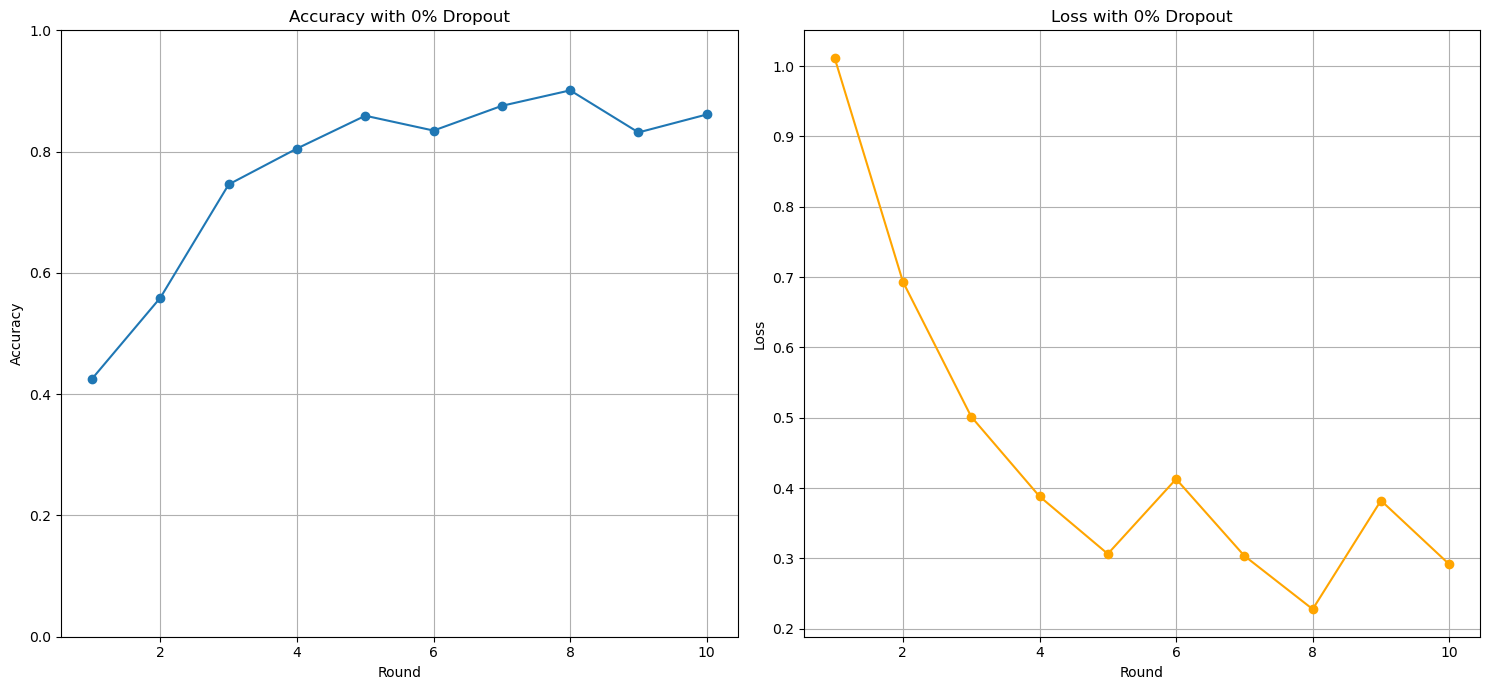

In [27]:


# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)



fit_metrics, eval_metrics = strategy.get_metrics_history()

rounds = list(range(1, len(eval_metrics) + 1))
train_accuracy_values = [
    metrics.get("train_accuracy", 0.0) for metrics in fit_metrics
]
train_loss_values = [metrics.get("train_loss", 0.0) for metrics in fit_metrics]

test_accuracy_values = [
    metrics.get("test_accuracy", 0.0) for metrics in eval_metrics
]
test_loss_values = [metrics.get("test_loss", 0.0) for metrics in eval_metrics]
test_f1_values = [metrics.get("test_f1", 0.0) for metrics in eval_metrics]
test_precision_values = [
    metrics.get("test_precision", 0.0) for metrics in eval_metrics
]
test_recall_values = [
    metrics.get("test_recall", 0.0) for metrics in eval_metrics
]

# cleanup_wandb_loggers()

results = {
    "rounds": rounds,
    "train_accuracy": train_accuracy_values,
    "train_loss": train_loss_values,
    "test_accuracy": test_accuracy_values,
    "test_loss": test_loss_values,
    "test_f1": test_f1_values,
    "test_precision": test_precision_values,
    "test_recall": test_recall_values,
}

for idx in range(len(results["rounds"])):
    wandb.log(
        {
            "round": idx,
            "train_accuracy": (
                results["train_accuracy"][-1]
                if idx > len(results["train_accuracy"]) - 1
                else results["train_accuracy"][idx]
            ),
            "train_loss": (
                results["train_loss"][-1]
                if idx > len(results["train_loss"]) - 1
                else results["train_loss"][idx]
            ),
            "test_accuracy": (
                results["test_accuracy"][-1]
                if idx > len(results["test_accuracy"]) - 1
                else results["test_accuracy"][idx]
            ),
            "test_loss": (
                results["test_loss"][-1]
                if idx > len(results["test_loss"]) - 1
                else results["test_loss"][idx]
            ),
            "test_f1": (
                results["test_f1"][-1]
                if idx > len(results["test_f1"]) - 1
                else results["test_f1"][idx]
            ),
            "test_precision": (
                results["test_precision"][-1]
                if idx > len(results["test_precision"]) - 1
                else results["test_precision"][idx]
            ),
            "test_recall": (
                results["test_recall"][-1]
                if idx > len(results["test_recall"]) - 1
                else results["test_recall"][idx]
            ),
        }
    )


# Visualize results
plt.figure(figsize=(15, 7))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(rounds, test_accuracy_values, 'o-', label=f'No dropout')
plt.title(f'Accuracy with {0*100:.0f}% Dropout')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.ylim(0, 1)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(rounds, test_loss_values, 'o-', color='orange', label=f'No dropout')
plt.title(f'Loss with {0*100:.0f}% Dropout')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [28]:
wandb.finish()

c:\Users\TrungNg\.conda\envs\python3.11\Lib\site-packages\wandb\sdk\lib\ipython.py:91: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display


round,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁▃▆▇▇▇██▇▇
test_f1,▁▃▆▇▇▇██▇▇
test_loss,█▅▃▂▂▃▂▁▂▂
test_precision,▁▃▆▇▇▇██▇▇
test_recall,▁▃▆▇▇▇██▇▇
train_accuracy,▁▄▆▇▇▇▇▇▇█
train_loss,█▆▄▃▃▂▂▂▂▁
round,9
test_accuracy,0.86122
test_f1,0.86122
